## Простые нейронные сети.


In [2]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

sns.set(font_scale=1.2, palette='Set2')
%matplotlib inline
print(torch.__version__)

2.2.0+cu121


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture4.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/nn_simple_examples.html" target="_blank">обучающий ноутбук</a> с занятия по нейронным сетям.

---
### <font color="blue"><i>Легкая часть</i></font>

---
### 1. Теория

Рассмотрим двухслойную нейронную сеть, которая принимает на вход $x\in\mathbb{R}$ и возвращает $y\in\mathbb{R}$. Выход первого слоя возвращает $u \in\mathbb{R}^2$. После первого слоя используется функция активации $\sigma(x) = \frac{1}{1 + \exp(-x)}$, после второго слоя функция активации не используется (или используется тождественная). Тем самым нашу нейронную можно представить в виде

$$\widehat{y}(x) = \sum_{h=1}^2 w_{2h}u_h(x) + b_2,$$

$$u_h(x) = \sigma(w_{1h}x + b_{1h}),$$

$$\text{где} \; h \in \{1, 2\}.$$



**1.** Нарисуйте схематически данную нейронную сеть. Сколько у нее обучаемых параметров?

(в $y$ идет сумма входящих в $\Sigma$)

У нее 7 обучаемых параметров: $w_{11}, b_{11}, w_{12}, b_{12}, w_{21}, w_{22}, b_2$

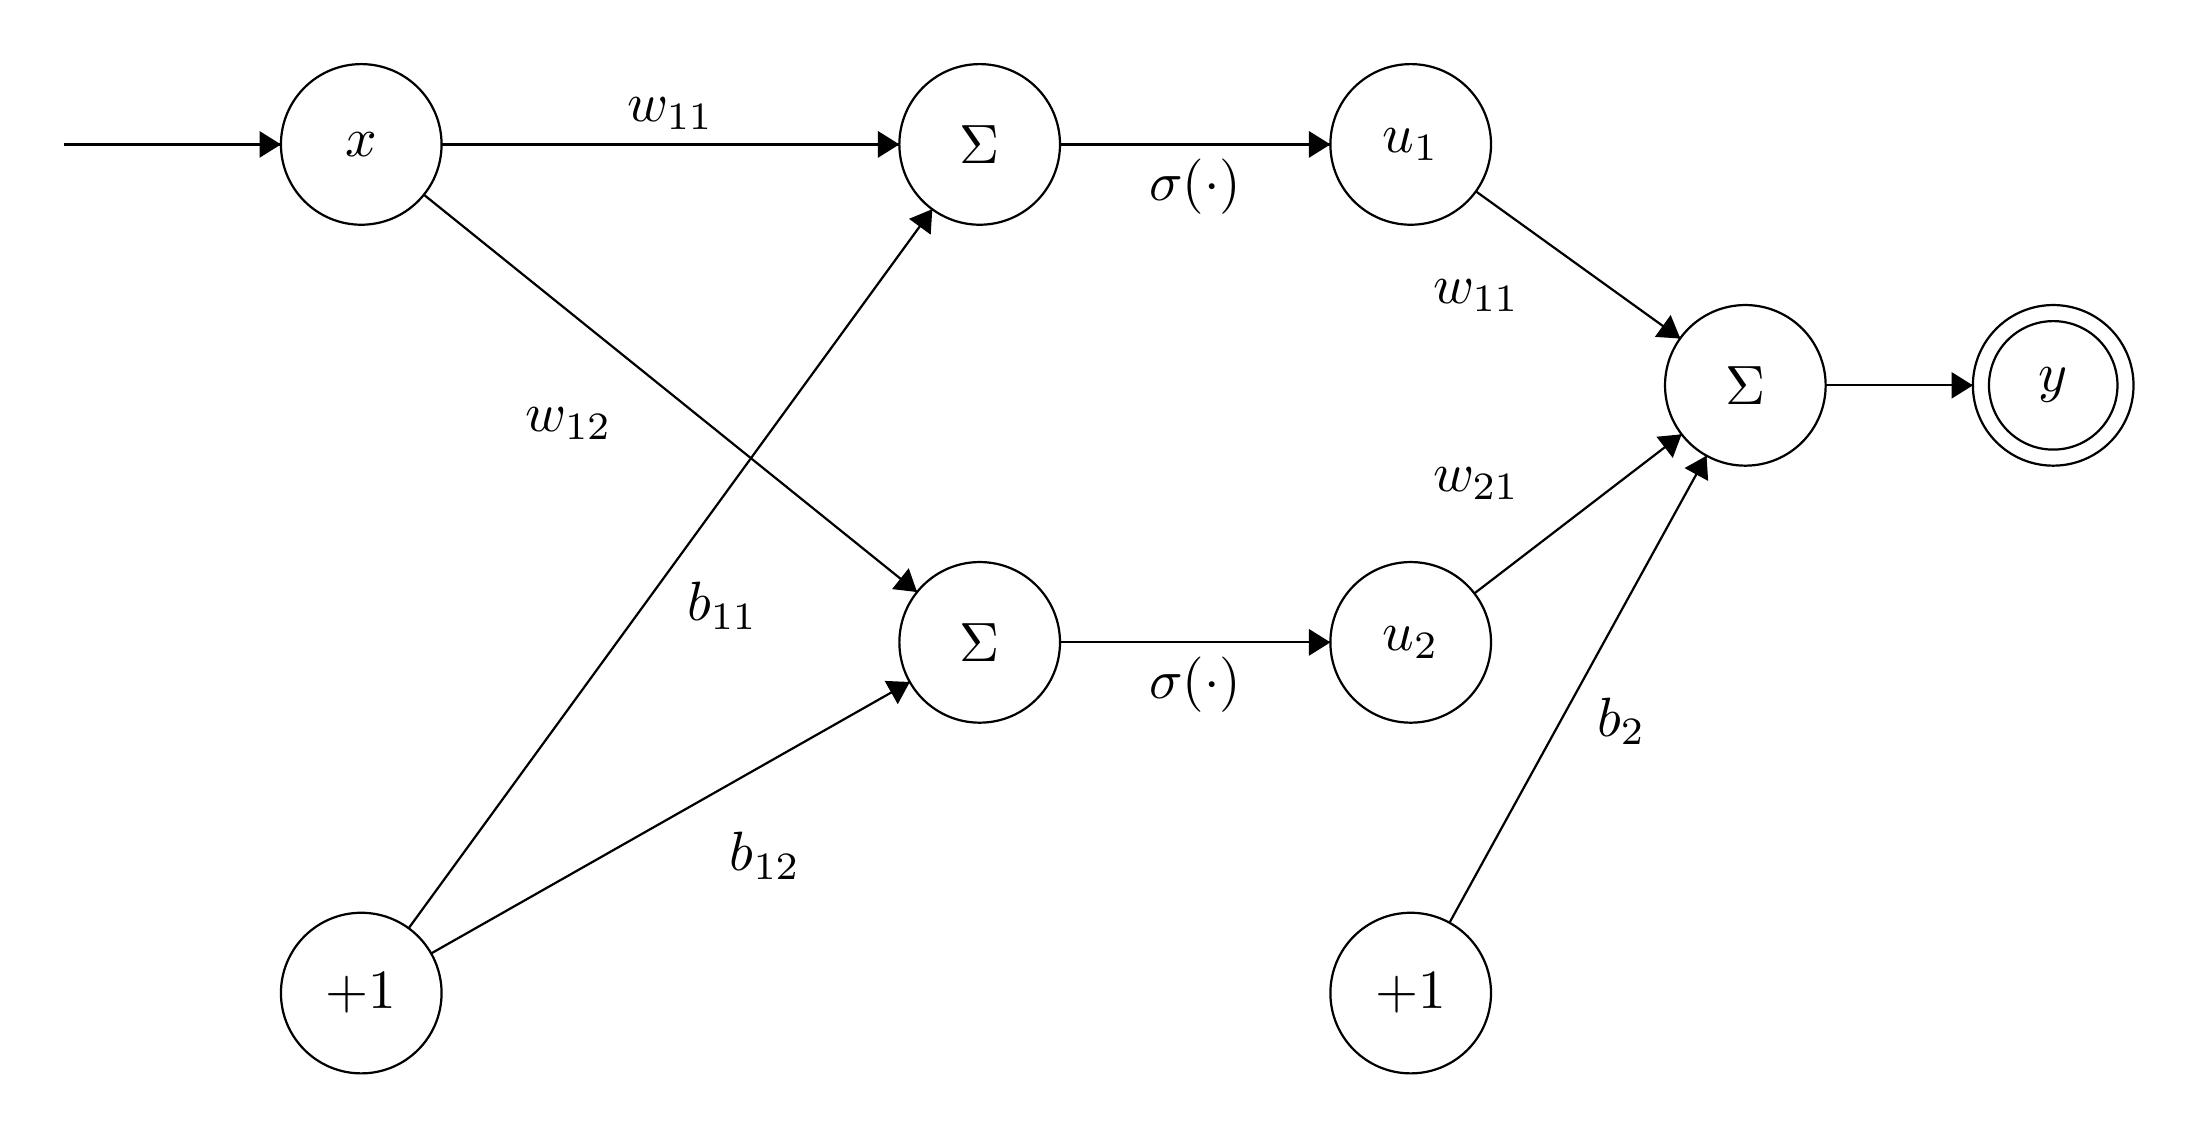

##### **2.** Пусть нам дана обучающая выборка $(X_1, Y_1), ..., (X_n, Y_n)$, где $X_i \in \mathbb{R}$ и $Y_i \in \mathbb{R}$. Нейронная сеть обучается по этой выборке, минимизируя заданную функцию $L$ &mdash; функцию ошибки. Положим, что $L$ &mdash; это MSE:
$$\text{MSE} = L(X, Y) = \frac{1}{n}\sum_{i=1}^n \big(Y_i - \widehat{y}(X_i)\big)^2.$$

Наша задача &mdash; найти оптимальные параметры нашей модели для минимизации $L(X, Y)$ на заданном наборе данных. Мы будем решать эту задачу с помощью градиентного спуска. Для этого нам понадобится выписать производные по всем параметрам сети. Конечно, в данном случае довольно просто выписать все производные напрямую. Однако мы воспользуемся следующей хитростью: мы будем считать производные поэтапно, причем начнем с конца вычислительной цепочки и, используя формулу производной сложной функции, последовательно посчитаем все необходимые производные. Этот процесс называется методом **обратного распространения ошибки (backpropagation)**.

**2.1.** Начнем с производной MSE по выходам сети

$$\frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} = \frac{\partial}{\partial \widehat{y}(X_i) } \frac{1}{n} \sum_{j=1}^n  (Y_j - \widehat y (X_j))^2 = \frac{-2}{n}(Y_i - \widehat y(X_i))$$

**2.2** Возьмем производные выходов сети по параметрам последнего слоя

$$\frac{\partial \widehat{y}(X_i)}{\partial w_{2h}} = \frac{\partial}{\partial w_{2h}}[\sum_{j=1}^2(w_{2j}u_j(X_i))+b_2] = u_h(x)$$

$$\frac{\partial \widehat{y}(X_i)}{\partial b_2} = \frac{\partial}{\partial b_{2}}[(\sum_{j=1}^2(w_{2j}u_j(X_i))+b_2] = 1$$

Также выпишем производные выходов сети по входам последнего слоя

$$\frac{\partial \widehat{y}(X_i)}{\partial u_h(X_i)} = \frac{\partial}{\partial u_h(X_i)}[\sum_{j=1}^2(w_{2j}u_j(X_i))+b_2] = w_{2h}$$

Теперь выпишем производные MSE по параметрам и входам последнего слоя. Для этого вспомните правило производной сложной функции из математического анализа. Обратите внимание на то, что нам не нужно прописывать все производные до конца, достаточно заполнить пропуски в записи ниже:

$$\frac{\partial\:\text{MSE}}{\partial w_{2h}} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} \frac{\partial \widehat{y}(X_i)}{\partial w_{2h}}$$

$$\frac{\partial\:\text{MSE}}{\partial b_2} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} \frac{\partial \widehat{y}(X_i)}{\partial b_2}$$

$$\frac{\partial\:\text{MSE}}{\partial u_h} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} \frac{\partial \widehat{y}(X_i)}{\partial u_h}$$

(посчитанные производные можно просто в это вставить, все есть)

**2.2.** Теперь будем разбираться с производными по параметрам первого слоя.

Для начала нам пригодится производная функции активации, запишите ее так, чтобы ответе осталась функция от $\sigma(x)$

$$\frac{\partial\:\sigma(x)}{\partial x} = \frac{\partial}{\partial x} \frac{1}{1+e^{-x}} = \frac{0-(-e^{-x})}{(1+e^{-x})^2} = \sigma^2(x) e^{-x} = \sigma^2(x)(\sigma^{-1}(x) - 1) = \sigma(x)-\sigma^2(x) = \sigma(x)(1-\sigma(x))$$

Теперь возьмем производные выходов первого слоя по его параметрам

$$\frac{\partial u_h(X_i)}{\partial w_{1h}} = \frac{\partial \sigma(w_{1h}X_i+b_{1h})}{\partial w_{1h}} = X_i \sigma(w_{1h}X_i+b_{1h})(1-\sigma(w_{1h}X_i+b_{1h})) = X_i u_h(X_i) (1-u_h(X_i))$$

$$\frac{\partial u_h(X_i)}{\partial b_{1h}} = \frac{\partial \sigma(w_{1h}X_i+b_{1h})}{\partial b_{1h}} = \sigma(w_{1h}X_i+b_{1h})(1-\sigma(w_{1h}X_i+b_{1h})) = u_h(X_i) (1-u_h(X_i))$$

Наконец, выпишем производные MSE по параметрам первого слоя. Так же как и раньше достаточно заполнить пропуски в записи ниже

$$\frac{\partial\:\text{MSE}}{\partial w_{1h}} = \; \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial u_h(X_i)} \frac{\partial u_h(X_i)}{\partial w_{1h}}$$

$$\frac{\partial\:\text{MSE}}{\partial b_{1h}} = \; \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial u_h(X_i)} \frac{\partial u_h(X_i)}{\partial b_{1h}}$$

(посчитанные производные можно просто в это вставить, все есть)

**3.** Пусть обучающая выборка очень большая. Что нужно делать в таком случае? Запишите, как нужно поменять правило обновления параметров.

Нужно разделить выборку на случайные батчи и использовать стохастический градиентный спуск SGD:

$\theta \in \{ w_{11}, b_{11}, w_{12}, b_{12}, w_{21}, w_{22}, b_2 \}$ - параметр, тогда его формула пересчета при шаге обучения $\eta$:

$$\theta_{new} = \theta_{old} - \eta \frac{\partial \text{MSE}}{\partial \theta}$$

При этом во всех формулах суммирумые индексы $i$ или $j$ не в отрезке $[1, n]$, а во множестве индексов $I$ текущего батча

**Вывод:**

Мы вывели формулы для градиентного спуска методом обратного распостранения ошибки.

---
### 2. Задача

Напишите нейронную сеть из задачи 1 с помощью библиотеки `pytorch`, используя Sequential-стиль. Перед выполнением задачи рекомендуется посмотреть <a href="https://miptstats.github.io/courses/ad_fivt/nn_simple_examples.html#3.-Готовые-модули-из-PyTorch" target="_blank">ноутбук</a> с занятия. Функция активации реализована как `torch.nn.Sigmoid`.

*Внимание.* Для выполнения задачи потребуется установить библиотеку `pytorch`. Альтернативный вариант &mdash; выполнение в <a href="https://colab.research.google.com" target="_blank">Google Colab</a>. Учитывайте, что при длительном бездействии Colab может сам завершить работу ядра.

In [3]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=2),
    nn.Sigmoid(),
    nn.Linear(in_features=2, out_features=1)
)
model

Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

Сгенерируем данные. Возьмите какую-либо нелинейную функцию $y(x)$.

In [4]:
sample_size = int(1e5)
x = sps.norm.rvs(size=(sample_size, 1))
y = x ** 2

x = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=1)

Обучите нейросеть на этих данных. Используйте код с занятия.

In [5]:
def pytorch_learn(model, step_count, x_train, y_train):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optim_func = nn.MSELoss()

    for i in range(step_count):
        y_pred = model(x_train)
        loss = optim_func(y_pred, y_train)
    
        loss.backward()
        optimizer.step()

        optimizer.zero_grad()

pytorch_learn(model, 5000, x_train, y_train)

Визуализируйте предсказания и посчитайте MSE на тестовой части данных.

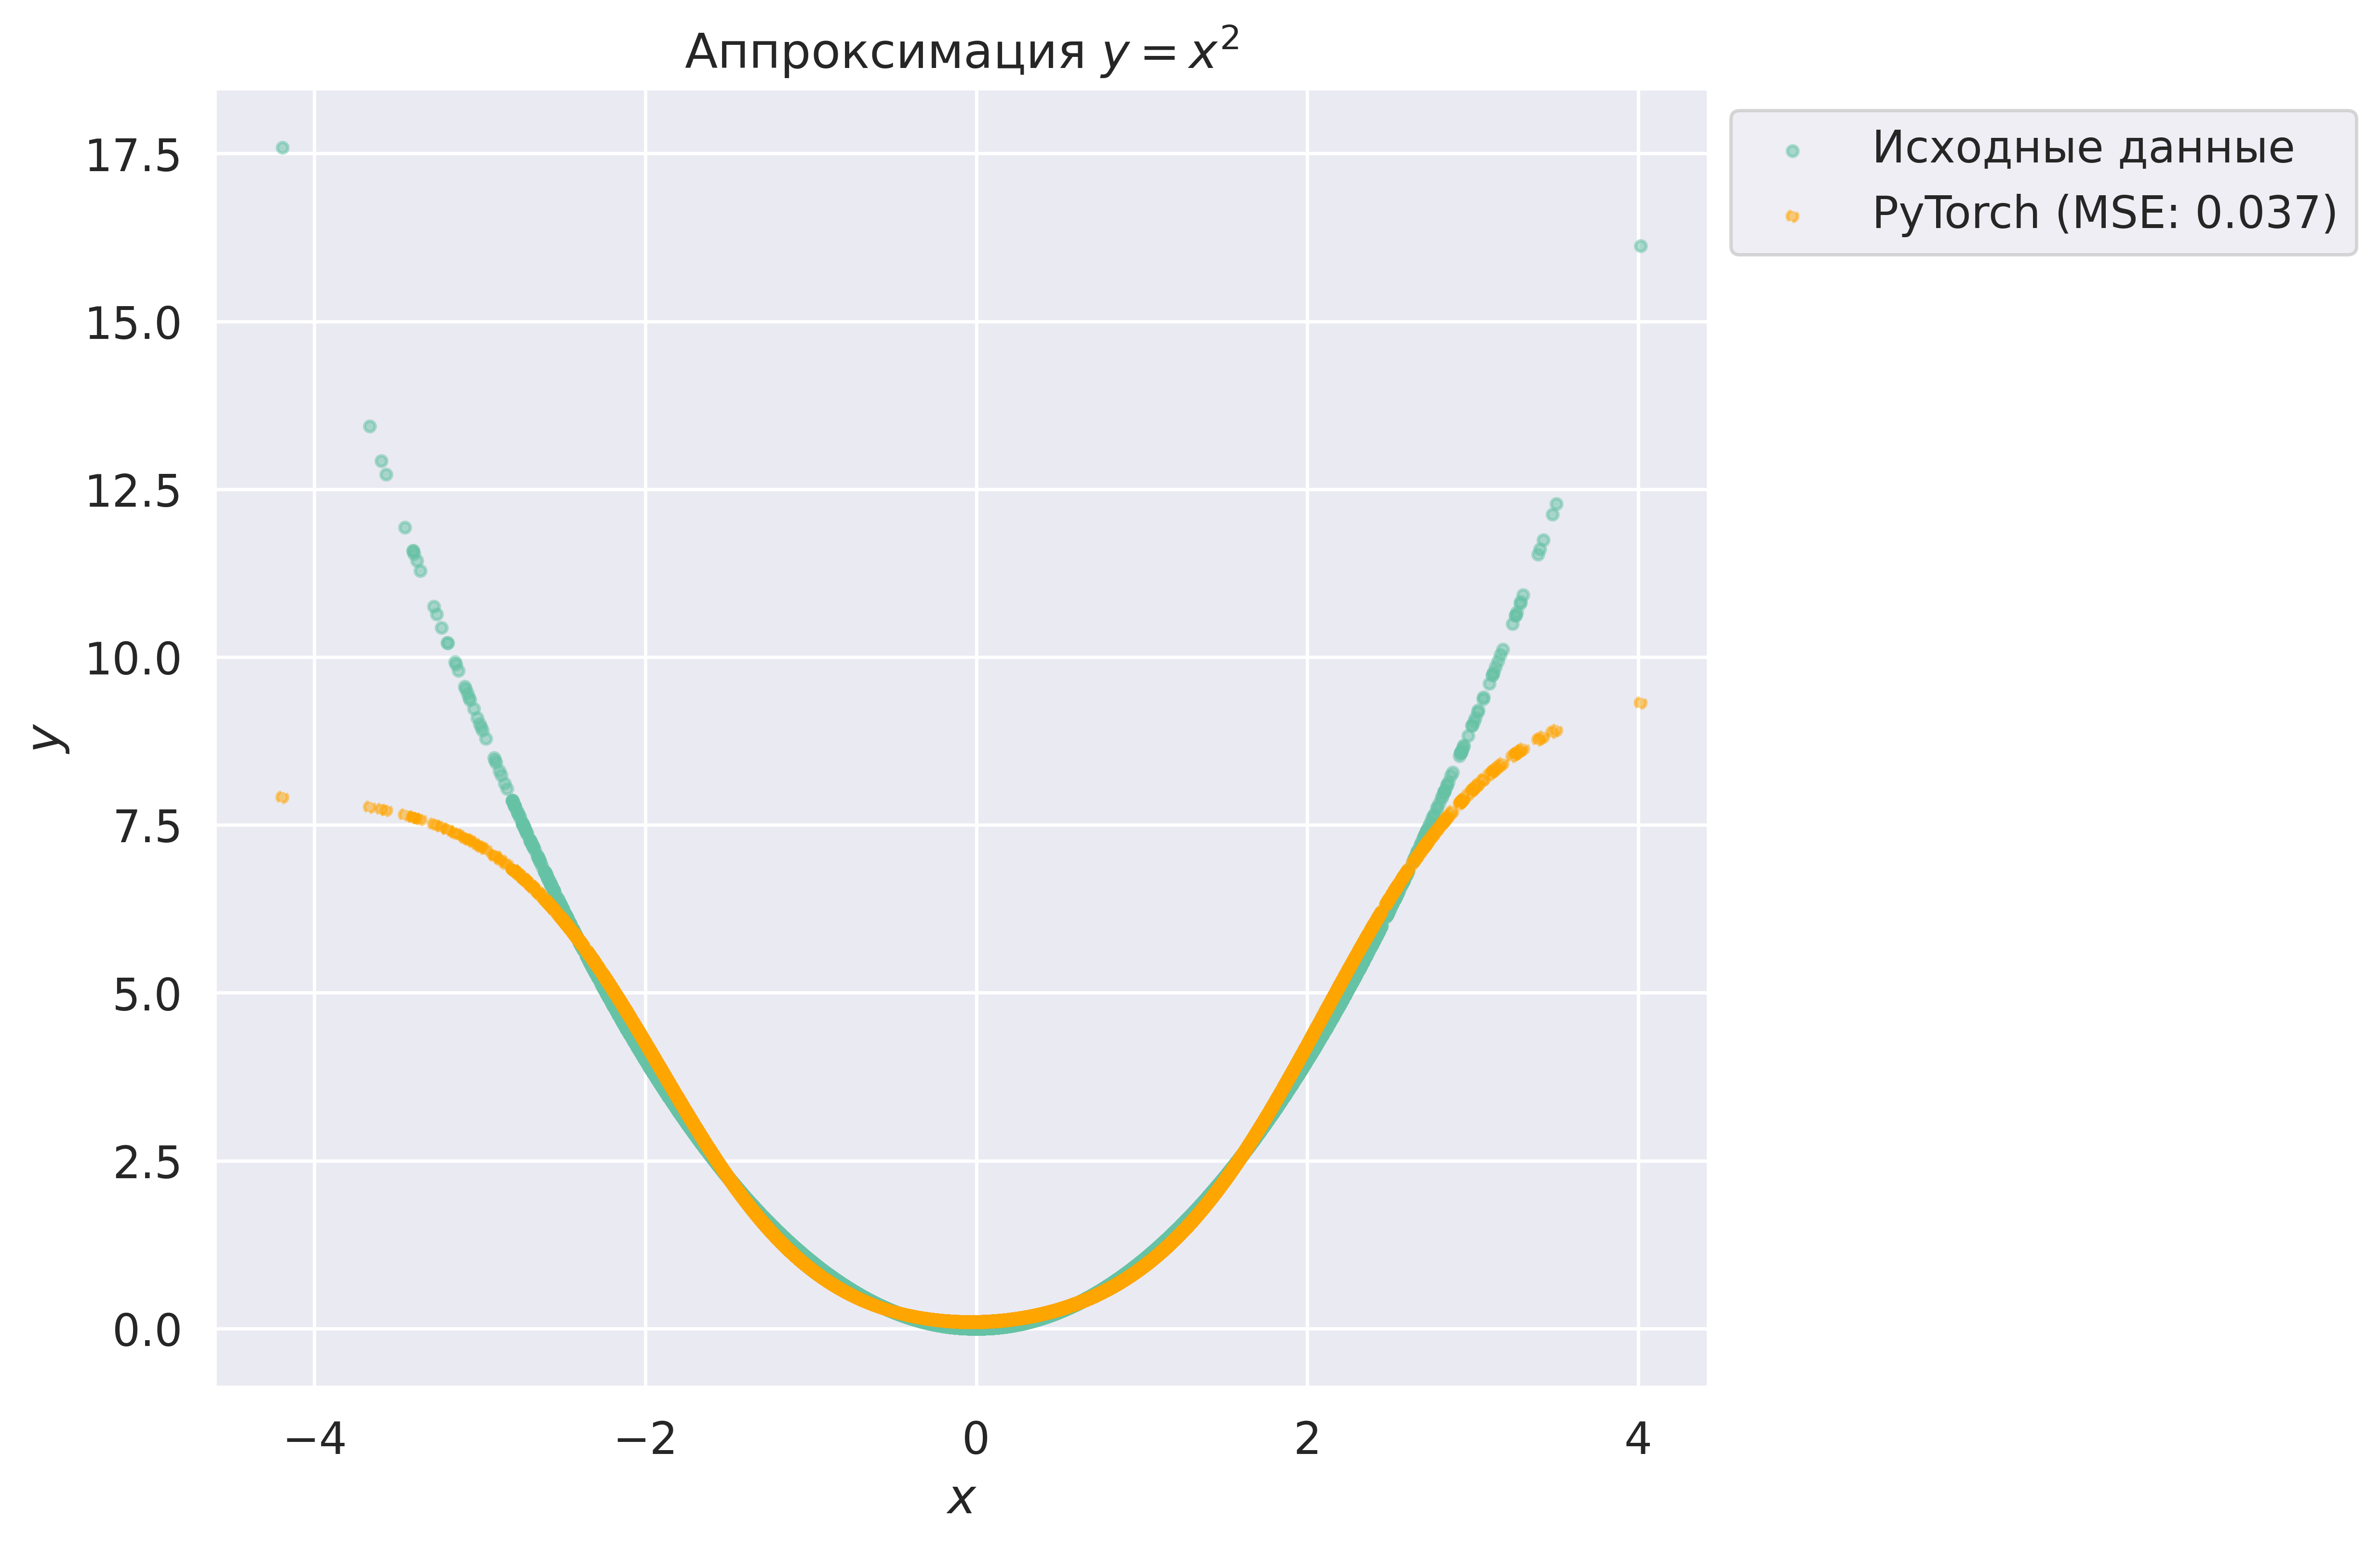

In [6]:
def show_progress(x, y, y_preds, title = "Аппроксимация $y = x^2$"):
    '''
    Визуализация процесса обучения.

    x, y -- объекты и таргеты обучающей выборки;
    y_preds -- предсказания модели (список);
    title -- название графика
    '''
    
    plt.figure(figsize=(8, 7), dpi=500)
    
    plt.scatter(x, y, label='Исходные данные', alpha=0.5, s=10)

    colors = ['orange', 'green', 'blue']
    labels = ['PyTorch', 'NeuralNetwork', 'LinearRegression']

    losses = [0] * len(y_preds)
    for i, (y_pred, loss) in enumerate(zip(y_preds, losses)):
        losses[i] = metrics.mean_squared_error(y, y_preds[i])
        plt.scatter(x, y_pred, color=colors[i], alpha=0.5, linestyle='--', 
                    s=10, label=f'{labels[i]} (MSE: {losses[i]:.3f})')

    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

show_progress(x_test, y_test, [model(x_test).detach()])

**Вывод:**
Мы смогли аппроксимировать нелинейную квадратичную фунцию простой нейросетью с несколькими нейронами, линейная регрессия такого не может. Из минусов - для больших значений x предсказания начинают расходиться. При этом учитывая что мы создавали точки с нормальным распределением и отколением в 1 мы получили приближение по почти всей выборке части. Если для нас этот хвост важен - можно попробовать улучшить функцию ошибки, чтобы квадратичные отклонения для больших $x$ входили с большим весом.

При этом сами графики несколько расходятся. Это можно улучшить изменением гиперпараметров, в том числе количества шагов и скорости обучения.

---
### <font color="orange"><i>Сложная часть</i></font>

---
### Задача 3.

Теперь реализуйте класс нейронной сети из задачи 1 в стиле scikit-learn, например, см. <a href="https://miptstats.github.io/courses/ad_fivt/task3.html#Задача-4." target="_blank">шаблон класса задачи 4 из задания 3</a>. Предусмотрите возможность обучения по случайным батчам. При реализации можно использовать только библиотеку `numpy`.

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
class NeuralNetwork:
    def __init__(self, in_features, mid_features, out_features):
        '''
        Инициализация нейронной сети.

        Аргументы:
        in_features -- число признаков во входном слое.
        mid_features -- число признаков в промежуточном слое.
        out_features -- число признаков в выходном слое.
        '''

        self.weights_1 = np.random.randn(in_features, mid_features)
        self.b_1 = np.zeros(mid_features)
        self.weights_2 = np.random.randn(mid_features, out_features)
        self.b_2 = np.zeros(out_features)
    
    def batch_split(self):
        '''
        Перемешивание для стохастического спуска и разделение на батчи

        Возвращает 
        list: Список кортежей (X_batch, Y_batch)
        '''
        indices = np.random.permutation(len(self.X))
        self.X = self.X[indices]
        self.Y = self.Y[indices]
        num_batches = len(self.X) // self.batch_size
        if len(self.X) % self.batch_size != 0:
            num_batches += 1
    
        batches = []
        for i in range(num_batches):
            start_idx = i * self.batch_size
            end_idx = (i + 1) * self.batch_size
            X_batch = self.X[start_idx:end_idx]
            Y_batch = self.Y[start_idx:end_idx]
            batches.append((X_batch, Y_batch))

        return batches
    
    def fit(self, X, Y, learning_rate=0.1, count_epochos=80, 
            is_stochastic=False, batch_size=512):
        '''
        Обучение нейронной сети.

        Аргументы:
        X -- numpy-матрица объект-признак размера (n, in_features);
        Y -- numpy-вектор значений целевого признака размера (n, out_features).
        learning_rate -- скорость обучения.
        count_epochos -- число эпох градиентного спуска
        is_stochastic -- стохастический градиентый спуск или нет
        batch_size -- размер батча (в случае стохастического градиентного спуска
        '''
        self.learning_rate = learning_rate
        self.is_stochastic = is_stochastic
        self.batch_size = batch_size
        self.X = X
        self.Y = Y
        
        for epoch in range(count_epochos):
            if self.is_stochastic:
                batches = self.batch_split()
                for (x, y) in batches:
                    self.forward_propagation(x)
                    self.backward_propagation(x, y)
                    self.update_parameters()
            else:
                self.forward_propagation(self.X)
                self.backward_propagation(self.X, self.Y)
                self.update_parameters()

        return self

    def forward_propagation(self, X):
        '''
        Прямой ход.

        Аргументы:
        X -- numpy-матрица объект-признак размера (n, in_features)
        '''
        self.u = sigmoid(X @ self.weights_1 + self.b_1)
        self.y_pred = self.u @ self.weights_2 + self.b_2

    def backward_propagation(self, X, Y):
        '''
        Обратный ход.

        Аргументы:
        X -- numpy-матрица объект-признак размера (n, in_features);
        Y -- numpy-вектор значений целевого признака размера (n, out_features).
        '''

        n, out_features = Y.shape
        cur = (self.y_pred - Y) / n
        self.derivative_b_2 = cur.sum(axis=0)
        cur = cur * self.u
        self.derivative_weights_2 = cur.sum(axis=0).reshape(-1, 1)
        cur = cur * (1 - self.u)
        self.derivative_b_1 = (self.weights_2.T * cur.sum(axis=0))[0]
        cur = cur * X
        self.derivative_weights_1 = self.weights_2.T * cur.sum(axis=0)

    def update_parameters(self):
        '''
        Обновление параметров шагом градиентного спуска.
        '''

        self.b_2 -= self.learning_rate * self.derivative_b_2
        self.weights_2 -= self.learning_rate * self.derivative_weights_2
        self.b_1 -= self.learning_rate * self.derivative_b_1
        self.weights_1 -= self.learning_rate * self.derivative_weights_1

    def predict(self, X):
        '''
        Вычисление предсказаний.

        Аргументы:
        X -- numpy-матрица объект-признак размера (n, in_features);

        Возвращает:
        predictions -- предсказания в виде numpy-вектора размера (n,).
        '''

        predictions = sigmoid(X @ self.weights_1 +
                              self.b_1) @ self.weights_2 + self.b_2

        return predictions


Обучите нейронную сеть на рассмотренных ранее данных, а также простую линейную регрессию. Для линейной регрессии стоит взять реализацию из `sklearn`. Сравните эту нейросеть, линейную регрессию и pytorch-сеть из задачи 2.

In [9]:
my_neural = NeuralNetwork(1, 2, 1)
my_neural.fit(x_train.numpy(), y_train.numpy(), is_stochastic=True)

linear_model = LinearRegression(fit_intercept=True) 
linear_model.fit(x_train, y_train)

LinearRegression()

Визуализируйте предсказания данных моделей и посчитайте MSE на тестовой части данных.

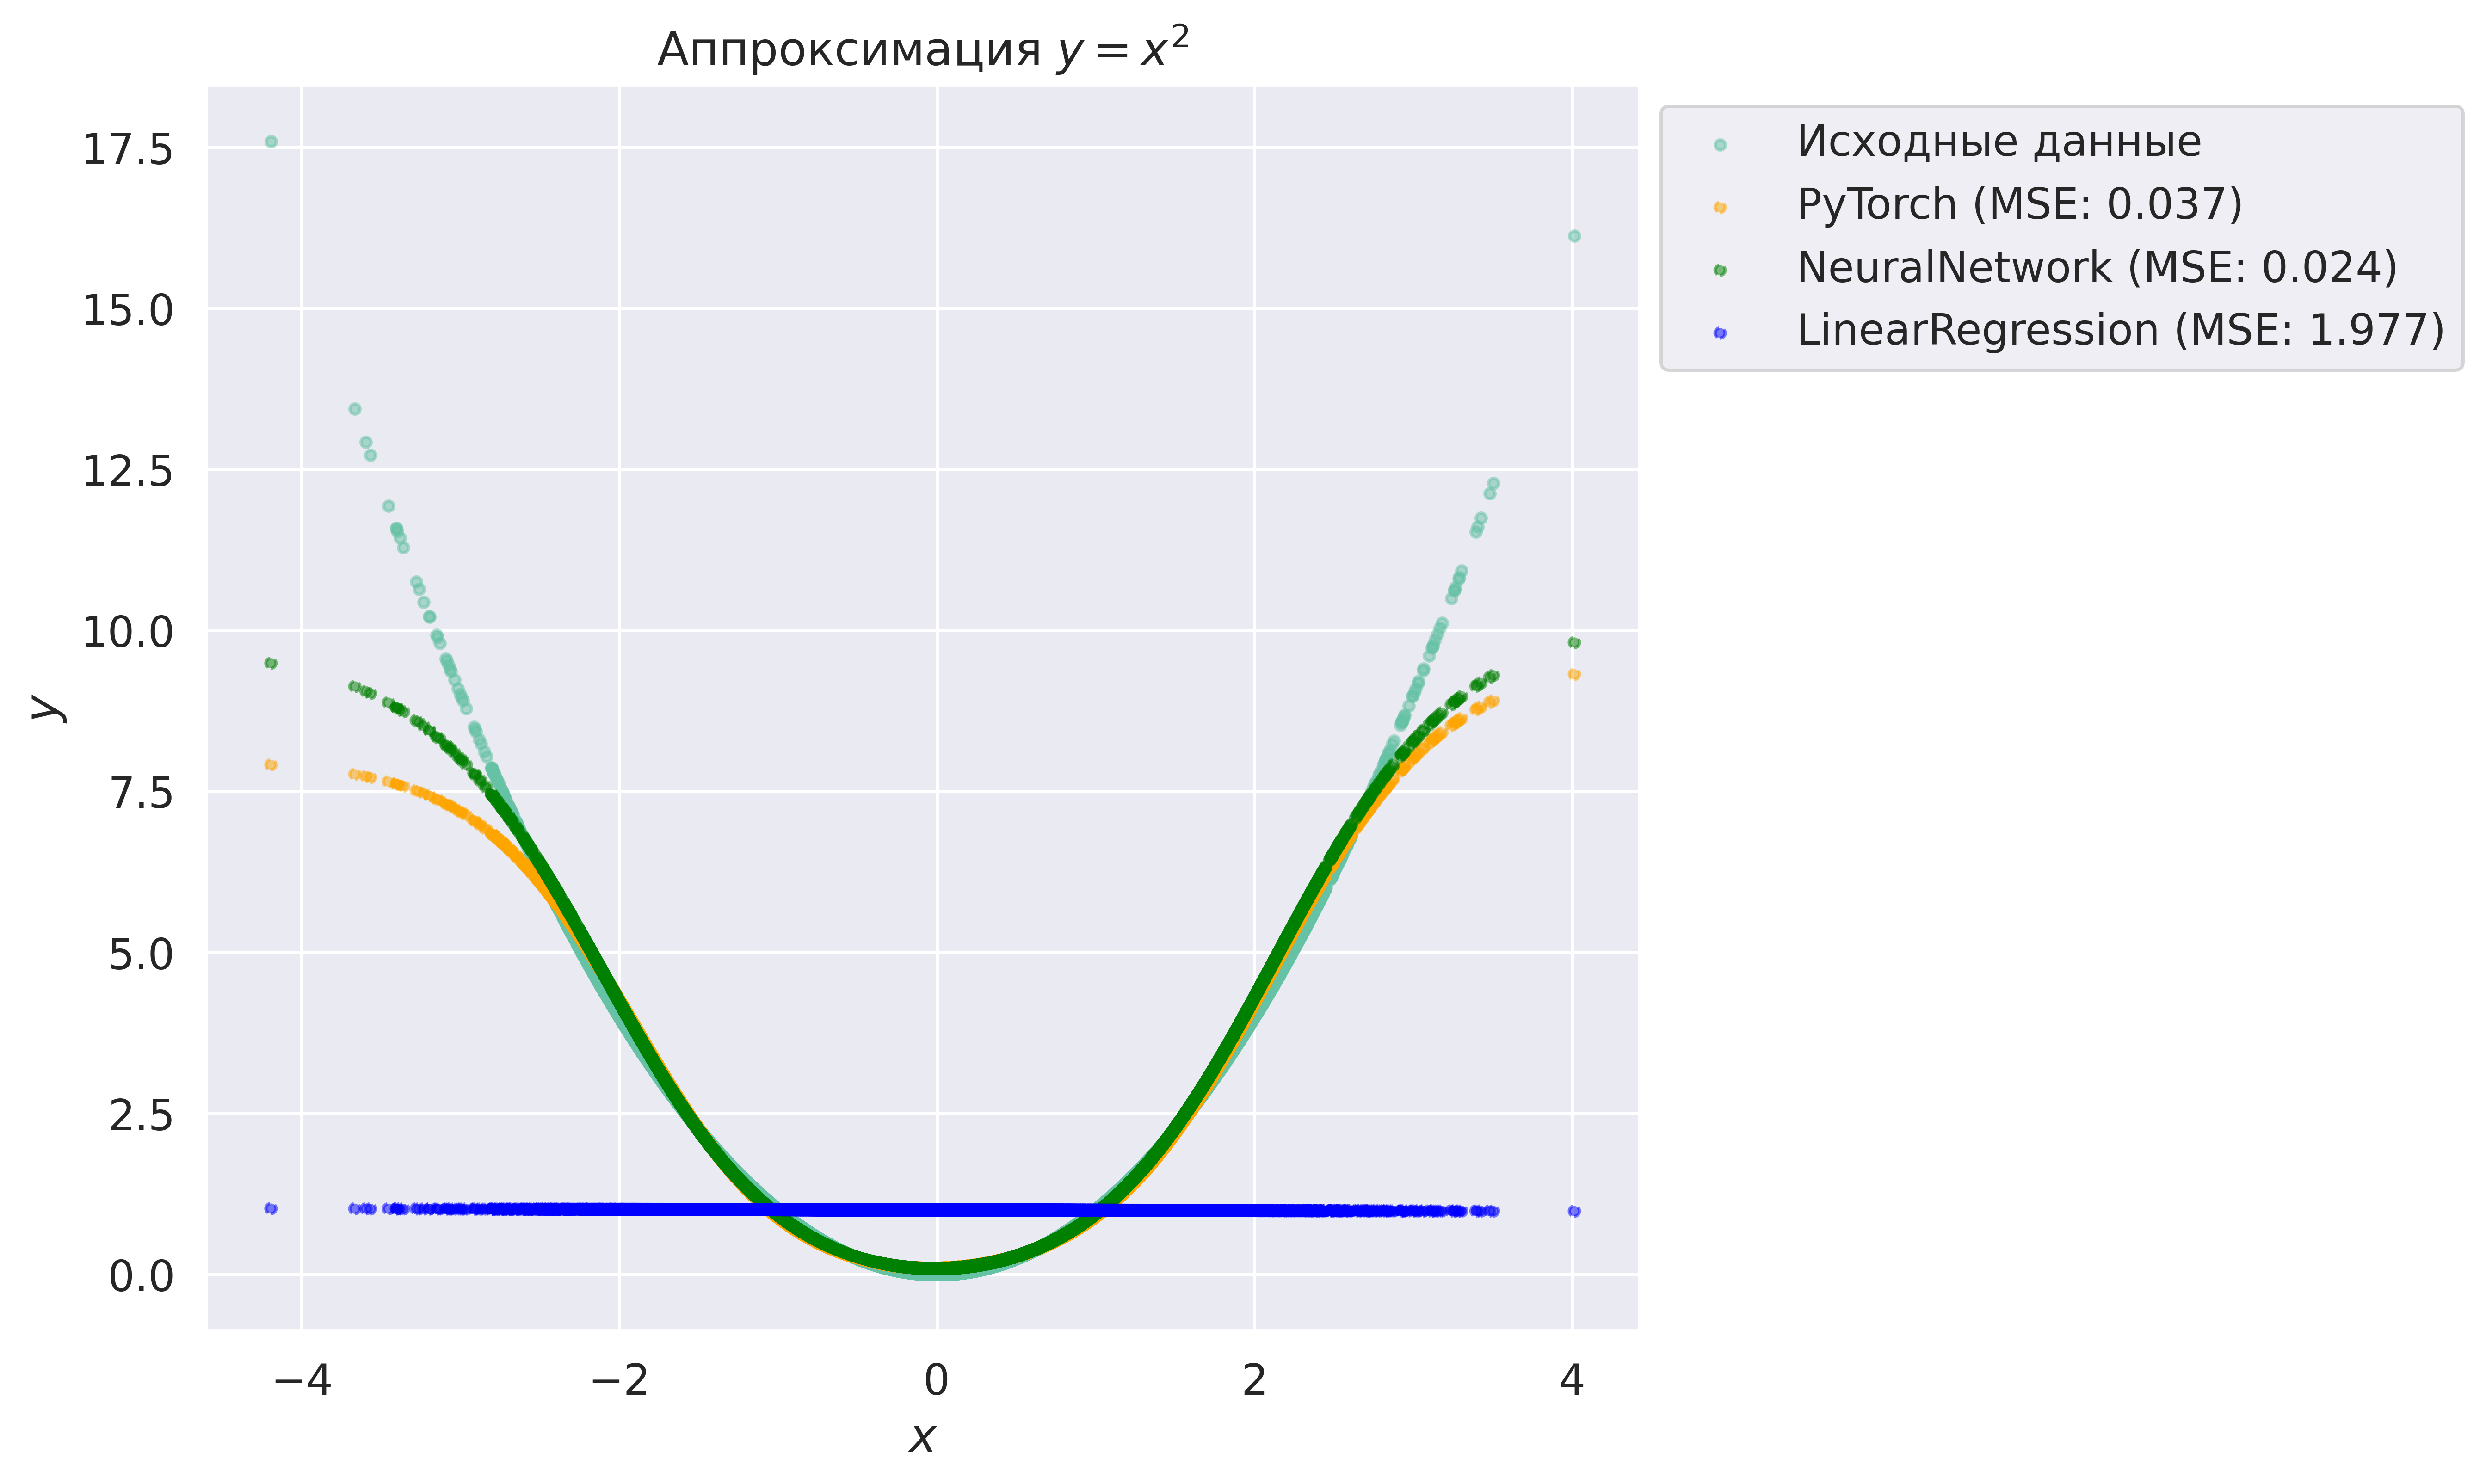

In [10]:
show_progress(x_test, y_test, [model(x_test).detach(), my_neural.predict(x_test).detach(), 
                               linear_model.predict(x_test)], r"Аппроксимация $y = x^2$")

Повторите вычисления для другой нелинейной функции $y(x)$.

Сгенерируем данные для функции $\sin(5x) / 5x$:

In [11]:
sample_size = int(1e5)
u = sps.norm.rvs(size=(sample_size, 1))
v = np.sin(5 * u) / (5 * u)

u = torch.tensor(u, dtype=torch.float32).reshape(-1, 1)
v = torch.tensor(v, dtype=torch.float32).reshape(-1, 1)

u_train, u_test, v_train, v_test = train_test_split(u, v, test_size=0.2, random_state=1)

Создадим и обучим модели:

In [12]:
pytorch_model = nn.Sequential(
    nn.Linear(in_features=1, out_features=2),
    nn.Sigmoid(),
    nn.Linear(in_features=2, out_features=1)
)
my_neural = NeuralNetwork(1, 2, 1)
linear_model = LinearRegression(fit_intercept=True) 

pytorch_learn(pytorch_model, 15000, u_train, v_train)
my_neural.fit(u_train.numpy(), v_train.numpy(), is_stochastic=True)
linear_model.fit(u_train, v_train)

LinearRegression()

Визуализируем приближения:

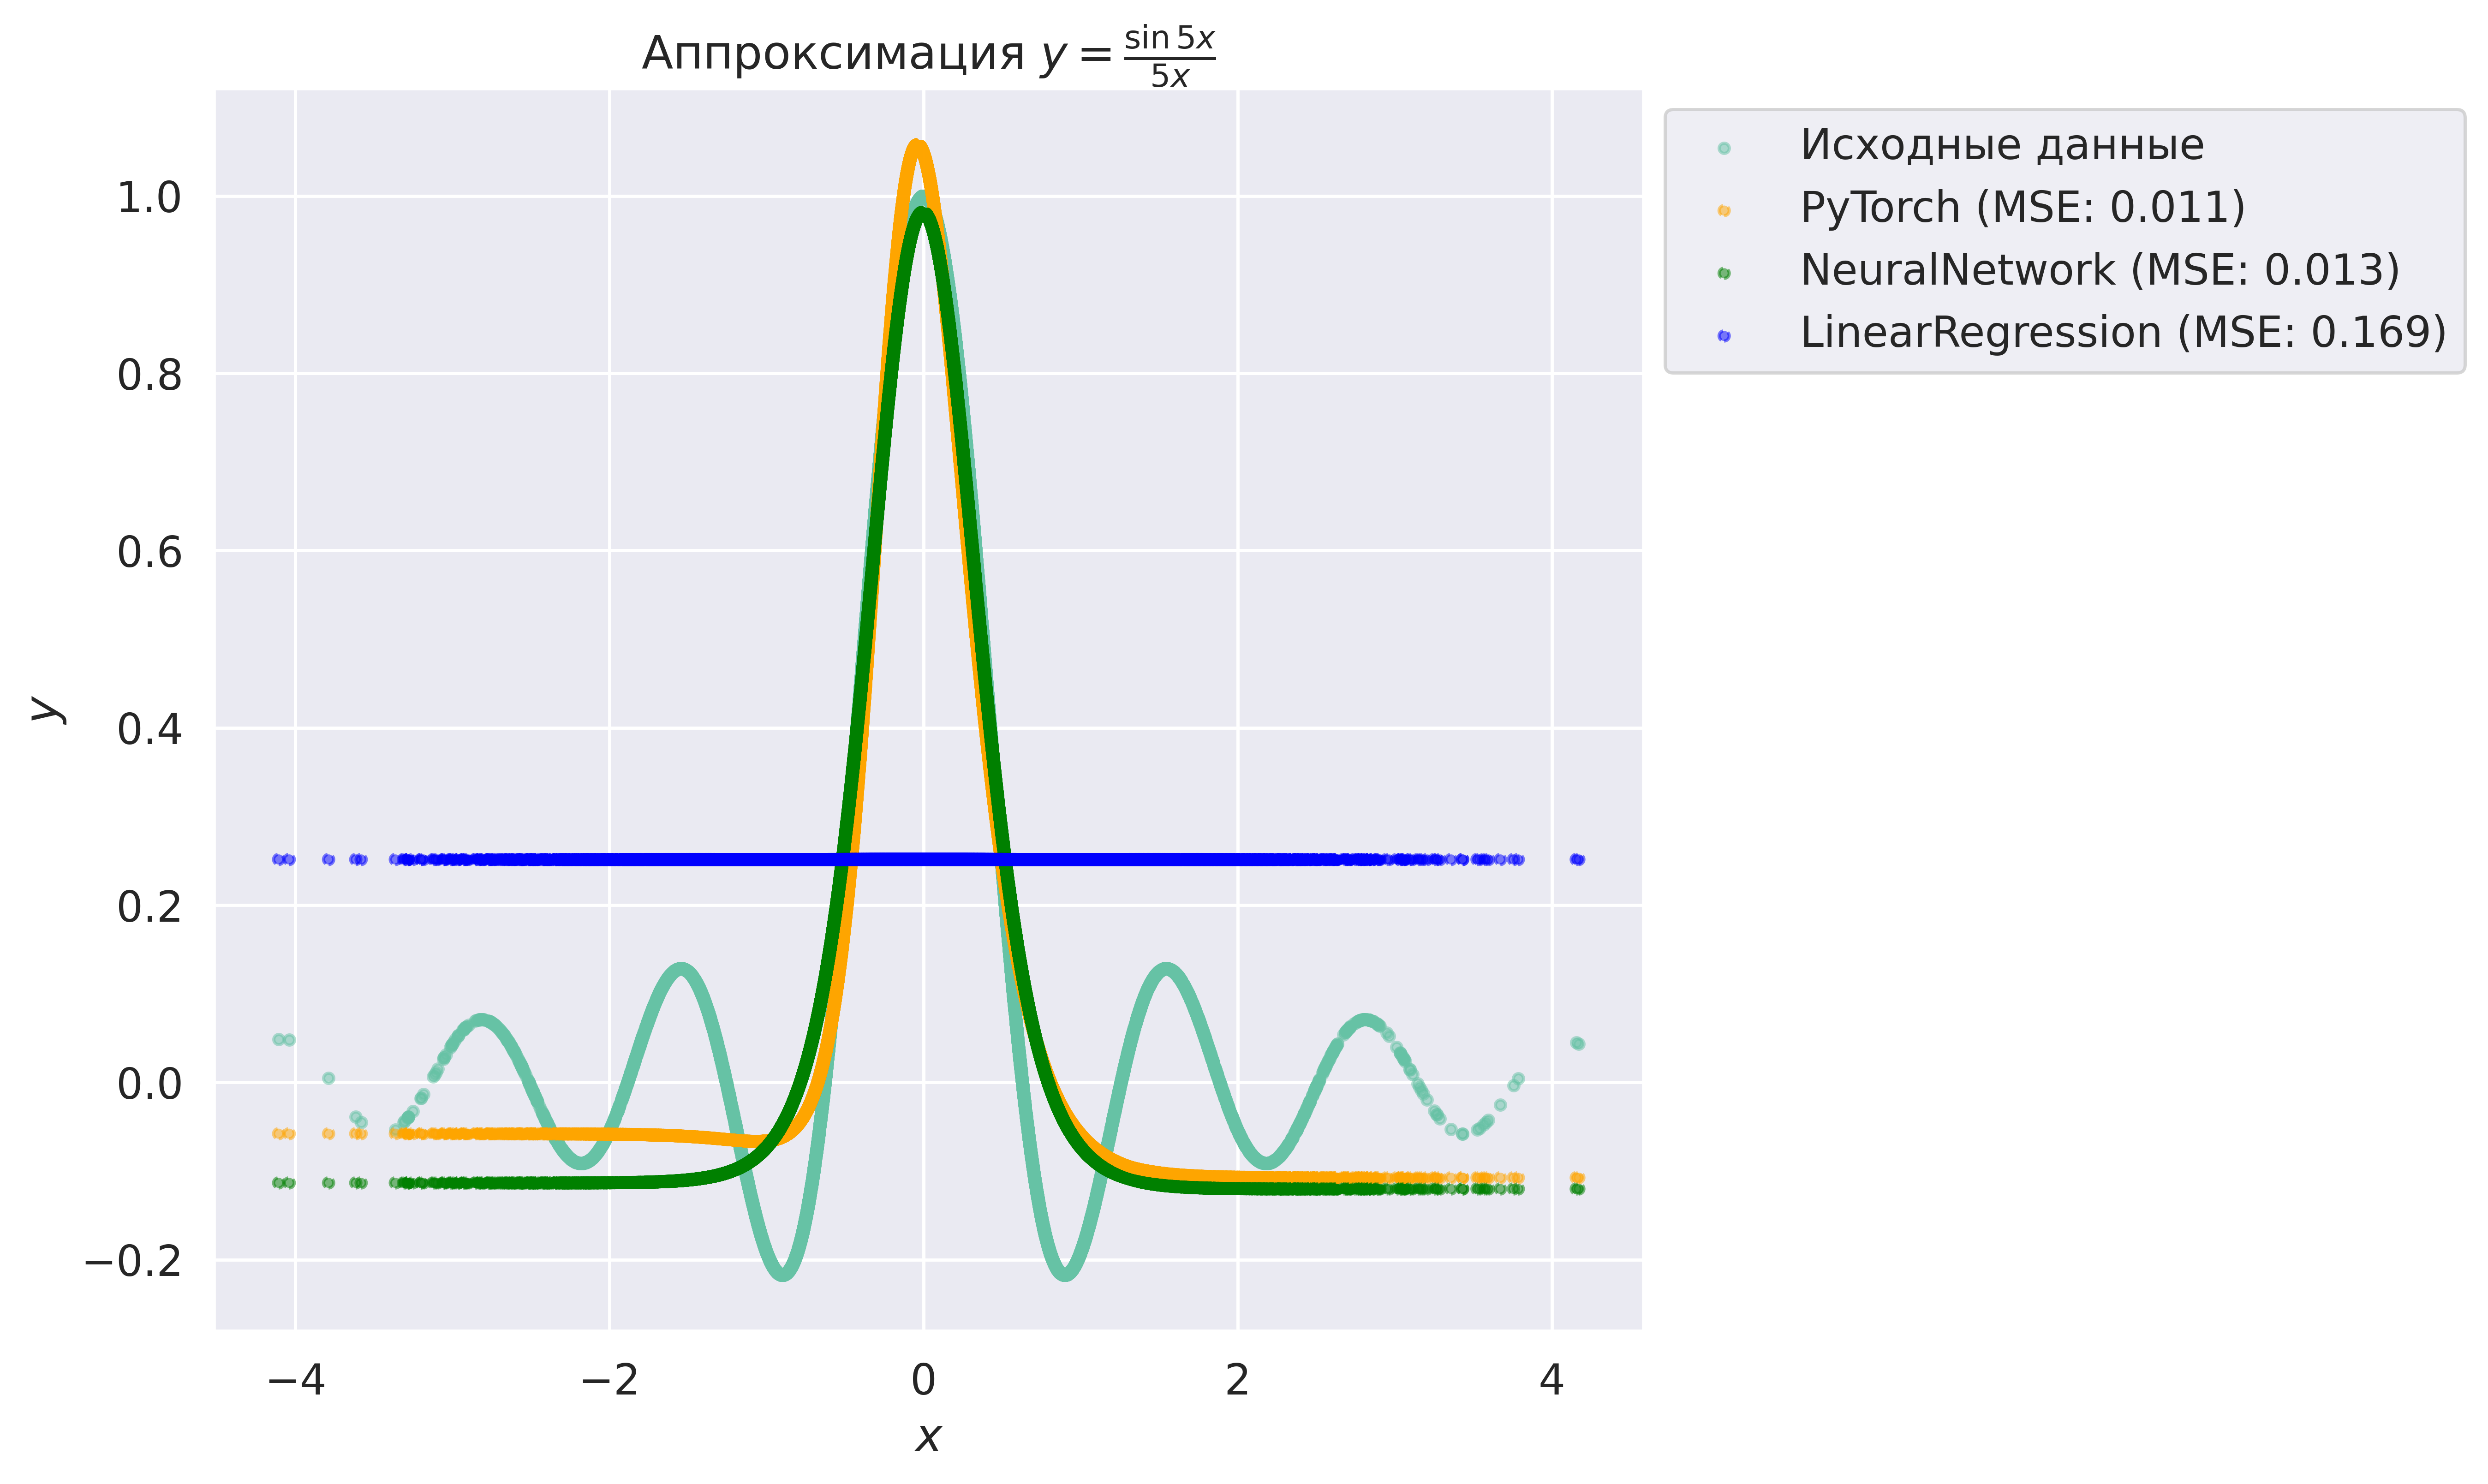

In [13]:
show_progress(u_test, v_test, [pytorch_model(u_test).detach(), 
                               my_neural.predict(u_test).detach(), 
                               linear_model.predict(v_test)], 
              r"Аппроксимация $y = \frac{\sin 5x}{5x}$")

**Вывод:**
Как видно из графиков, $y = x^2$ одинаково хорошо приближается и нашей нейросетью, и нейросетью из PyTorch. Расхождения вызваны в первую очередь различиями в выборе гиперпараметров - размера выборки, шага обучения, числа шагов. Линейная регрессея же уже такую функцию приблизить хорошо не может.

В приближении же функции $y = \frac{\sin 5x}{5x}$ совсем близко находятся графики приближений обеих нейросетей, а линейная регрессия все так же плоха. При это нейросети приближают только первый холмик функции, а остальные колебания не видят. Связано это скорее всего с моделью нашей нейросети. Для более точной аппроксимации надо изменить ее структуру, добавить нейроны или поменять функции активации.

Таким образом, простым добавлением нелинейности с помощью функции активации мы можем аппроксимировать уже более широкий класс нелинейных функций, чего раньше нельзя было достичь одной только линейной регрессией. При этом самописная нейросеть работает не хуже библиотечной.